## Natural Gas ARIMA Model

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

### Data Preprocessing

In [2]:
df = pd.read_csv('pricedata.csv')

In [3]:
df.head()

,Symbol,Date,Open,High,Low,Close,Volume,Currency
0,Brent Oil,1/4/2000,23.90,24.70,23.89,24.39,32509,USD
1,Brent Oil,1/5/2000,24.25,24.37,23.70,23.73,30310,USD
2,Brent Oil,1/6/2000,23.55,24.22,23.35,23.62,44662,USD
3,Brent Oil,1/7/2000,23.57,23.98,23.05,23.09,34826,USD
4,Brent Oil,1/10/2000,23.04,23.78,23.04,23.73,26388,USD


In [4]:
# There are four different kinds of oil in this dataset, but I only care about Natural Gas
df = df[df['Symbol'] == 'Natural Gas'].reset_index(drop = True)

In [5]:
df['Date'] = [dt.datetime.strptime(date_str, '%m/%d/%Y').date() for date_str in df['Date']]

In [6]:
df.head()

,Symbol,Date,Open,High,Low,Close,Volume,Currency
0,Natural Gas,2000-01-04,2.130,2.200,2.130,2.176,30152,USD
1,Natural Gas,2000-01-05,2.180,2.200,2.125,2.168,27946,USD
2,Natural Gas,2000-01-06,2.165,2.220,2.135,2.196,29071,USD
3,Natural Gas,2000-01-07,2.195,2.230,2.155,2.173,28455,USD
4,Natural Gas,2000-01-10,2.180,2.255,2.165,2.216,28916,USD


In [7]:
df.set_index(df['Date'], inplace = True)

In [9]:
df['Year'] = [day.year for day in df['Date']]

In [8]:
df['Month'] = [day.month for day in df['Date']]

In [10]:
df.head()

,Symbol,Date,Open,High,Low,Close,Volume,Currency,Month,Year
Date,,,,,,,,,,
2000-01-04,Natural Gas,2000-01-04,2.130,2.200,2.130,2.176,30152,USD,1,2000
2000-01-05,Natural Gas,2000-01-05,2.180,2.200,2.125,2.168,27946,USD,1,2000
2000-01-06,Natural Gas,2000-01-06,2.165,2.220,2.135,2.196,29071,USD,1,2000
2000-01-07,Natural Gas,2000-01-07,2.195,2.230,2.155,2.173,28455,USD,1,2000
2000-01-10,Natural Gas,2000-01-10,2.180,2.255,2.165,2.216,28916,USD,1,2000


In [13]:
close = df.groupby(by = ['Year', 'Month'])['Close'].mean().reset_index()

In [18]:
years, months = df[['Year', 'Month']]

In [25]:
close.set_index(pd.Index([dt.datetime(year, month, 1).date() for (year, month) in zip(close['Year'], close['Month'])]), inplace = True)

In [28]:
close.drop(columns = ['Year', 'Month'], inplace = True)

In [31]:
close.head()

,Close
2000-01-01,2.385368
2000-02-01,2.614250
2000-03-01,2.828261
2000-04-01,3.028842
2000-05-01,3.596409


We can use either the opening or closing price of the stock (there is no significant difference). Our team arbitrarily chose to train our models on the daily closing price of the stock.

### Check for Stationarity

In [32]:
close = close['Close']

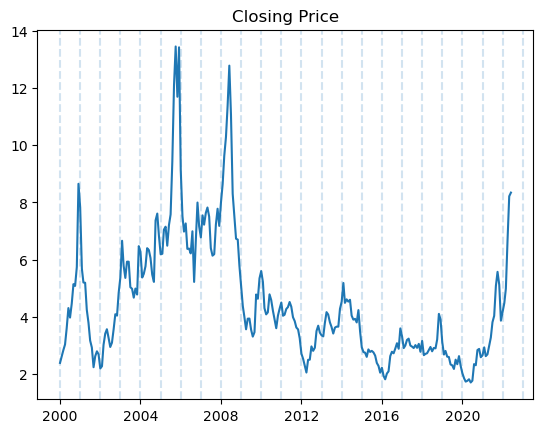

In [34]:
plt.plot(close)
plt.title('Closing Price')
for year in range(2000, 2024):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), linestyle = '--', alpha = 0.2)

plt.show()

In order to train an ARIMA model, our data must be stationary. We must satisfy 3 requirements to consider our data to be stationary:

1. Constant mean: Our data does not satisfy this; it looks like the mean before 2009 is about 6 while the mean after 2009 is about 4
2. Constant variance: Our data seems to satisfy this requirement, aside from a very random events (sudden spikes or drops in the data)
3. No seasonality: This one seems to be satistfied. Although the price exhibits oscillatory behavior between 2011 and 2020, it does not seem to be related to the time of year

We can also perform the Augmented Dickey-Fuller test, which mathematically determines if a dataset is stationary.

In [35]:
ad_fuller_test = adfuller(close)
print(f"ADF Statistic: {ad_fuller_test[0]}")
print(f"p-value: {ad_fuller_test[1]}")

ADF Statistic: -2.098913780232343
p-value: 0.2449516002024259


As you can see from the ADF test above, we do not have statistical evidence that our data is stationary. This makes sense because when we look at the graph of closing price above, we see a decrease in the mean from before 2009 compared with after 2009.

In conclusion, our data is not currently stationary. We will try to fix this by taking the first difference and checking this for stationarity.

In [44]:
first_diff = close.diff().dropna()
first_diff

2000-02-01    0.228882
2000-03-01    0.214011
2000-04-01    0.200581
2000-05-01    0.567567
2000-06-01    0.707000
                ...   
2022-02-01    0.310139
2022-03-01    0.499257
2022-04-01    1.728896
2022-05-01    1.506322
2022-06-01    0.128324
Name: Close, Length: 269, dtype: float64

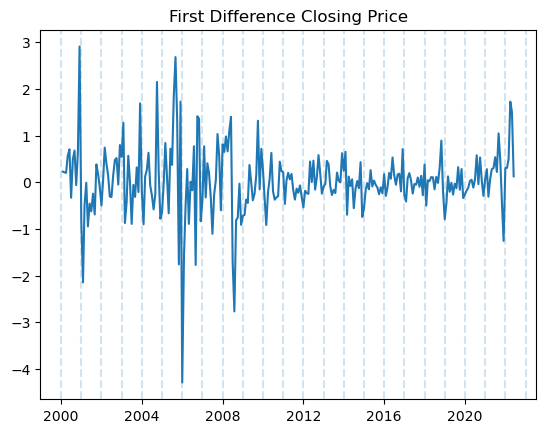

In [37]:
plt.plot(first_diff)
plt.title('First Difference Closing Price')
for year in range(2000, 2024):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), linestyle = '--', alpha = 0.2)

plt.show()

In [38]:
ad_fuller_test = adfuller(first_diff)
print(f"ADF Statistic: {ad_fuller_test[0]}")
print(f"p-value: {ad_fuller_test[1]}")

ADF Statistic: -7.483092080177394
p-value: 4.7156746070739e-11


As you can see from the above graph, our data now seems to have a constant mean. We may question whether it has a constant variance (it seems to be greater before 2010 than after 2010), but in general there is no signficant change. Finally, we don't see any seasonality in our data. These visual perceptions are confirmed by the ADF test, which yielded a p-value very close to 0.

We are now ready to determine the parameters for our ARIMA model.

### Determining Parameters of ARIMA Model

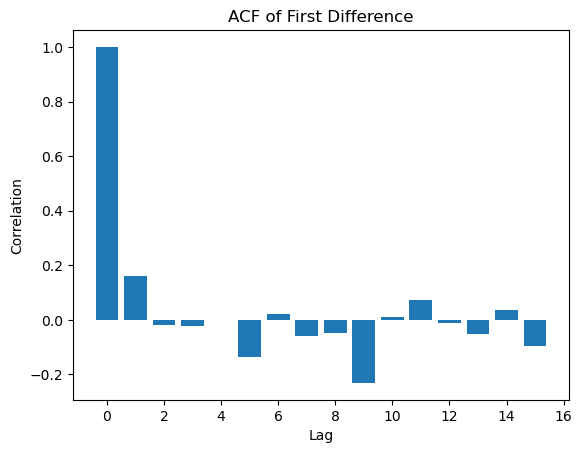

In [39]:
ACF = acf(first_diff)
plt.bar(range(16), ACF[:16])
plt.title("ACF of First Difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

There seem to be significant lags at 1 and 5. Because lags 2, 3, and 4 seem to be insignificant, we will first try an ARIMA model with MA(1).

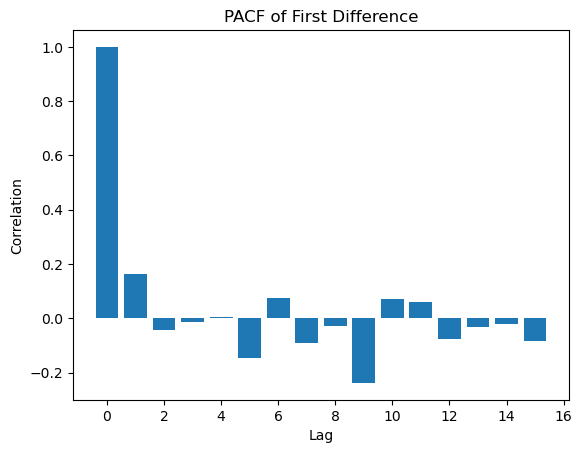

In [41]:
PACF = pacf(first_diff)
plt.bar(range(16), PACF[:16])
plt.title("PACF of First Difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

Similarly, we see strong lags for the PACF at 1 and 5 (and possibly 2). So we will first try an ARIMA model with AR(2).

### Training the ARIMA Model

We will train our model up to the end of 2021 and try to predict the oil price for the first 6 months of 2022

In [59]:
first_diff.index = range(len(first_diff.index))

In [115]:
# train = first_diff[107:239] # Training Data from 2009 to 2020
train = first_diff[:239] # Training Data up to 2020
test = first_diff[239:264] # Testing Data is all of 2021 and 2022

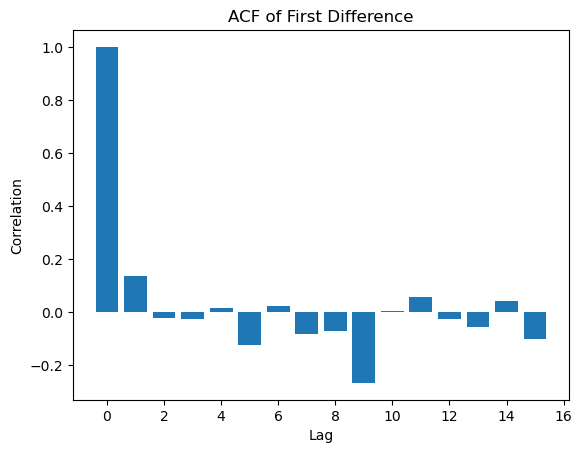

In [116]:
ACF = acf(train)
plt.bar(range(16), ACF[:16])
plt.title("ACF of First Difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

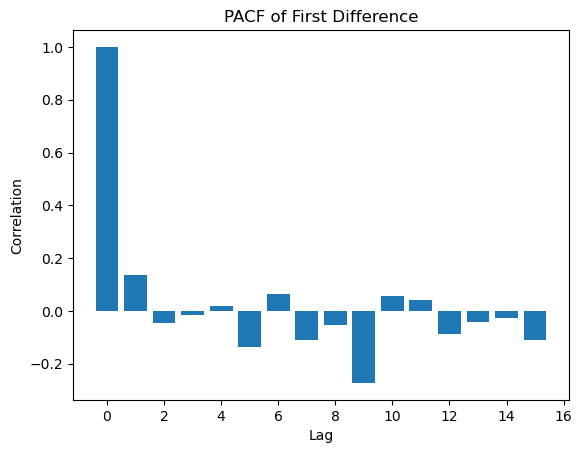

In [117]:
PACF = pacf(train)
plt.bar(range(16), PACF[:16])
plt.title("PACF of First Difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

In [118]:
model = ARIMA(train, order = (4, 0, 5))
model_fit = model.fit()

C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [119]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  239
Model:                 ARIMA(4, 0, 5)   Log Likelihood                -248.495
Date:                Thu, 09 May 2024   AIC                            518.989
Time:                        09:49:53   BIC                            557.231
Sample:                             0   HQIC                           534.400
                                - 239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0052      0.032     -0.163      0.870      -0.067       0.057
ar.L1         -0.1835      0.116     -1.580      0.114      -0.411       0.044
ar.L2         -0.0961      0.130     -0.737      0.4

In [120]:
pred = model_fit.predict(start = len(train), end = len(train) + len(test) - 1)
pred = pd.DataFrame(pred).reset_index(drop = True)

In [121]:
test.reset_index(drop = True, inplace = True)

In [122]:
result = pd.concat([test, pred], axis = 1)

In [123]:
result

,Close,predicted_mean
0,-0.258739,0.027953
1,-0.176792,0.014268
2,-0.119152,0.102251
3,0.028152,-0.117459
4,0.054758,0.124135
5,-0.113227,-0.007817
6,0.063267,0.057131
7,0.579346,-0.094232
8,-0.039694,0.091273
9,0.532445,-0.017595


<Axes: >

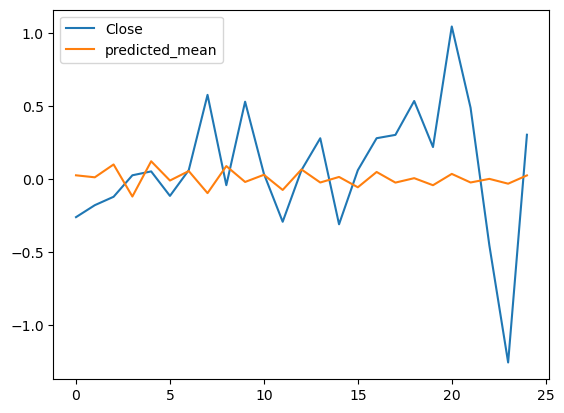

In [124]:
result.plot()

## Rolling Forecast Origin

In [31]:
first_diff[:test['Date'][3]]

Date
2000-01-05   -0.008
2000-01-06    0.028
2000-01-07   -0.023
2000-01-10    0.043
2000-01-11    0.044
              ...  
2021-12-31    0.169
2022-01-03    0.085
2022-01-04   -0.098
2022-01-05    0.165
2022-01-06   -0.070
Name: Close, Length: 5623, dtype: float64

In [39]:
first_diff

0      -0.008
1       0.028
2      -0.023
3       0.043
4       0.044
        ...  
5736   -0.241
5737   -1.420
5738    0.231
5739    0.044
5740   -0.520
Name: Close, Length: 5741, dtype: float64

In [40]:
predictions = pd.Series(dtype = 'float64')

for day in range(len(train) + 1, len(first_diff)):
    train_data = first_diff[:day - 1]
    model = ARIMA(train_data, order = (5, 0, 5))
    model_fit = model.fit()
    pred = model_fit.predict(day)
    print(pred)
    predictions.loc[day] = pred.loc[day]

C:\Users\david\AppData\Local\Temp\ipykernel_31448\2656936466.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5620    0.009394
dtype: float64


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5621    0.021127
dtype: float64



KeyboardInterrupt

